# DM-31046 Zooniverse cutouts

This notebook is to try out the `ZoonverseCutoutsTask` implemented on DM-31046. The notebook may evolve as that task is improved (i.e. to include source selection via sql query) on a subsequent ticket.

In [1]:
import glob
import os
import pandas as pd
import sqlite3

import IPython.display

import lsst.daf.butler as dafButler
from lsst.pipe.tasks.zooniverseCutouts import ZooniverseCutoutsTask

import sys
sys.path.append('..')

# local to ap_pipe-notebooks
import apdbPlots as pla
import diaObjectAnalysis as doa

In [2]:
# The URL where the output files can be accessed by zooniverse.
url_root = "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/"
# The path to write the PNG and manifest files to.
output_path = "/scratch/ebellm/zooniverse/"

In [3]:
# gen 3, meredith's fakes run

In [4]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [5]:
collection = 'u/mrawls/DM-31053-HSC-fakes'
dbSchema = 'mrawls_DM31053'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

## Load sources from apdb

In [6]:
connection, tables = doa.connectToApdb('lsstdevapdb1', dbType='postgres', schema=dbSchema)

In [7]:
tables

{'obj': '"DiaObject"',
 'src': '"DiaSource"',
 'sso': '"SSObject"',
 'forcedsrc': '"DiaForcedSource"',
 'proto': '"ApdbProtoVisits"',
 'match': '"DiaObject_To_Object_Match"'}

In [8]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
#sources = pd.read_sql_query(f'select * from {tables["src"]} LIMIT 100;', connection)
sources = pd.read_sql_query(f'select * from {tables["src"]} ORDER BY RANDOM() LIMIT 1000;', connection)

CPU times: user 78.2 ms, sys: 8.04 ms, total: 86.3 ms
Wall time: 16.9 s


In [9]:
sources

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,ixxPSF,iyyPSF,ixyPSF,extendedness,spuriousness,flags,pixelId,filterName,isDipole,bboxSize
0,804056532517253,374418,5026024416870960,0,0,0,None,56750.266134,150.250879,0.0,...,0.163048,0.002217,0.002217,0.0,0.0,1320,0,y,False,45
1,505972917272961,235612,505972917272961,0,0,0,None,56744.287740,150.332363,0.0,...,0.178754,-0.010564,-0.010564,0.0,0.0,40,0,z,False,24
2,7699373123178339,3585300,7699373123178339,0,0,0,None,57038.568894,150.877697,0.0,...,0.040459,0.001459,0.001459,0.0,0.0,4,0,z,False,11
3,140900697112899,65612,140900697112899,0,0,0,None,56741.417458,150.302280,0.0,...,0.191622,0.008244,0.008244,0.0,0.0,25167208,0,y,False,25
4,141826262565848,66043,141826262565848,0,0,0,None,56741.420702,149.846375,0.0,...,0.246414,0.008993,0.008993,0.0,0.0,41944428,0,y,False,860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7700094677681195,3585636,7700094677681195,0,0,0,None,57038.572779,149.724076,0.0,...,0.038012,0.006827,0.006827,0.0,0.0,41944392,0,z,False,78
996,5035428247765963,2344804,7714835005442681,0,0,0,None,56979.623791,150.627769,0.0,...,0.101492,-0.011841,-0.011841,0.0,0.0,41943608,0,y,False,16
997,5039779049636486,2346830,7688914877809842,0,0,0,None,56979.643564,150.935935,0.0,...,0.093792,-0.003979,-0.003979,0.0,0.0,25165868,0,y,False,17
998,7709661717332609,3590091,7709661717332609,0,0,0,None,57038.615014,150.405142,0.0,...,0.056931,-0.005788,-0.005788,0.0,0.0,25165824,0,z,False,11


In [10]:
# NOTE: need to run this to add ccd and visit identifiers to the sources.
# Apdb doesn't have another way to get those, and they are necessary for retrieving the images.
pla.addVisitCcdToSrcTable(sources, instrument=instrument, gen='gen3', butler=butler)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,ixyPSF,extendedness,spuriousness,flags,pixelId,filterName,isDipole,bboxSize,visit,ccd
0,804056532517253,374418,5026024416870960,0,0,0,None,56750.266134,150.250879,0.0,...,0.002217,0.0,0.0,1320,0,y,False,45,1872,18
1,505972917272961,235612,505972917272961,0,0,0,None,56744.287740,150.332363,0.0,...,-0.010564,0.0,0.0,40,0,z,False,24,1178,12
2,7699373123178339,3585300,7699373123178339,0,0,0,None,57038.568894,150.877697,0.0,...,0.001459,0.0,0.0,4,0,z,False,11,17926,100
3,140900697112899,65612,140900697112899,0,0,0,None,56741.417458,150.302280,0.0,...,0.008244,0.0,0.0,25167208,0,y,False,25,328,12
4,141826262565848,66043,141826262565848,0,0,0,None,56741.420702,149.846375,0.0,...,0.008993,0.0,0.0,41944428,0,y,False,860,330,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7700094677681195,3585636,7700094677681195,0,0,0,None,57038.572779,149.724076,0.0,...,0.006827,0.0,0.0,41944392,0,z,False,78,17928,36
996,5035428247765963,2344804,7714835005442681,0,0,0,None,56979.623791,150.627769,0.0,...,-0.011841,0.0,0.0,41943608,0,y,False,16,11724,4
997,5039779049636486,2346830,7688914877809842,0,0,0,None,56979.643564,150.935935,0.0,...,-0.003979,0.0,0.0,25165868,0,y,False,17,11734,30
998,7709661717332609,3590091,7709661717332609,0,0,0,None,57038.615014,150.405142,0.0,...,-0.005788,0.0,0.0,25165824,0,z,False,11,17950,91


In [11]:
sources['instrument'] = instrument


In [12]:
sources.to_csv(output_path + 'sources.csv')

## Use the above selected sources to make cutouts

In [13]:
config = ZooniverseCutoutsTask.ConfigClass()
config.urlRoot = url_root
config.outputPath = output_path
zooniverseCutouts = ZooniverseCutoutsTask(config)

In [14]:
%%time
zooniverseCutouts.generate_images(sources, butler, collection)

CPU times: user 57min 32s, sys: 10min 55s, total: 1h 8min 27s
Wall time: 1h 31min 20s


NOTE: `generate_images` took about 3.5 minutes on 100 sources without the lru_cache, vs. about 30 seconds with the cache on (and all 100 sources were on the same detector/visit).

In [15]:
manifest = zooniverseCutouts.make_manifest(sources)
manifest.to_csv(os.path.join(config.outputPath, "manifest.csv"), index=False)

## Display some images

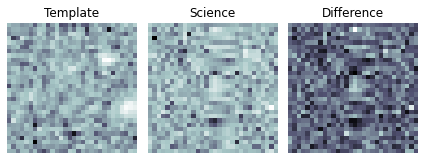

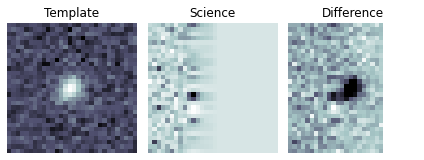

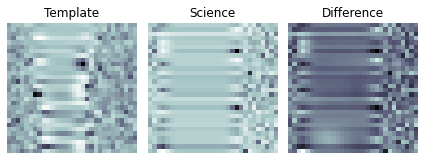

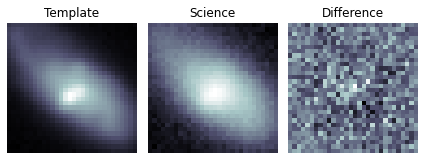

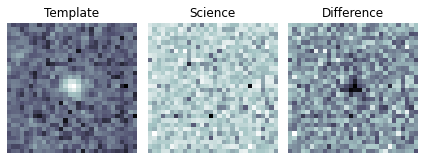

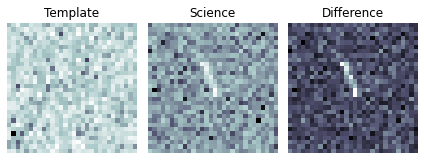

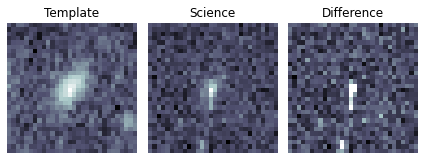

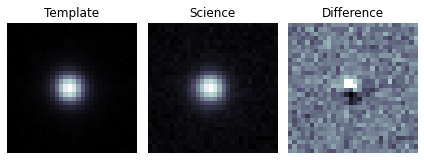

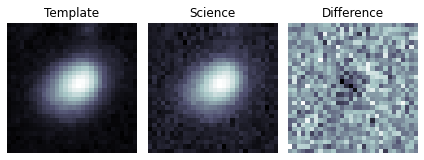

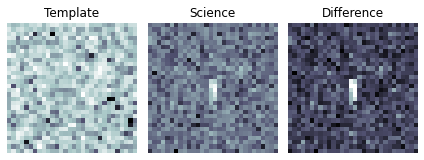

In [16]:
files = glob.glob(os.path.join(config.outputPath, "images", "*.png"))
for file in files[:10]:
    image = IPython.display.Image(file)
    IPython.display.display(image)

### Submit data to Panoptes
copied from DM-27813-Crowded-Field-to-Zooniverse.ipynb

In [18]:
import panoptes_client
import sys,os,os.path,logging,json
# Add panoptes API client debugging to Stderr
os.environ['PANOPTES_DEBUG'] = 'true'
os.environ['PANOPTES_DEBUG']

/home/ebellm/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


'true'

In [19]:


# Get access to the API client logs
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]



In [20]:
client = panoptes_client.Panoptes.connect(login="interactive")

Enter your Zooniverse credentials...


Username:  ebellm
 ······························


urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): www.zooniverse.org:443
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /users/sign_in HTTP/1.1" 200 None
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /users/sign_in HTTP/1.1" 200 None
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /users/sign_in HTTP/1.1" 200 None
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /users/sign_in HTTP/1.1" 200 None


In [21]:
project = panoptes_client.Project.find(slug='ebellm/alert-production-zoo')

urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /oauth/token HTTP/1.1" 200 None
panoptes_client - DEBUG - params={'slug': 'ebellm/alert-production-zoo'}
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/projects?slug=ebellm%2Falert-production-zoo HTTP/1.1" 200 None


In [22]:
project.id

'11152'

In [23]:
print([(ss.id, ss.display_name) for ss in project.links.subject_sets])

[]


In [24]:
# make a new subject set
subject_set = panoptes_client.SubjectSet()

subject_set.links.project = project
subject_set.display_name = 'u/mrawls/DM-31053-HSC-fakes'

subject_set.save()
project.reload()

panoptes_client - DEBUG - json={'subject_sets': {'display_name': 'u/mrawls/DM-31053-HSC-fakes', 'links': {'project': '11152'}}}
redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /api/subject_sets HTTP/1.1" 201 None
panoptes_client - DEBUG - params={'slug': None}
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/projects/11152 HTTP/1.1" 200 None


In [25]:
payload_dict = {"subject_set_imports": {"source_url": f"{url_root}manifest.csv", "links": {"subject_set": subject_set.id}}}

json.dumps(payload_dict)

'{"subject_set_imports": {"source_url": "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv", "links": {"subject_set": "97143"}}}'

In [26]:
# request the import via the API client (custom path as this isn't an exposed resource in the client)
# this should be added to the Zooniverse python client / cli tools to improve the user experience
# https://github.com/zooniverse/panoptes-python-client/issues/255
json_response, etag = client.post(path='/subject_set_imports', json=payload_dict)

panoptes_client - DEBUG - json={'subject_set_imports': {'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv', 'links': {'subject_set': '97143'}}}
redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /api/subject_set_imports HTTP/1.1" 201 None


In [27]:
json_response

{'subject_set_imports': [{'id': '8',
   'href': '/subject_set_imports/8',
   'created_at': '2021-08-04T23:57:22.312Z',
   'updated_at': '2021-08-04T23:57:22.312Z',
   'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv',
   'links': {'subject_set': '97143', 'user': '1649740'}}],
 'links': {'subject_set_imports.subject_set': {'href': '/subject_sets/{subject_set_imports.subject_set}',
   'type': 'subject_sets'},
  'subject_set_imports.user': {'href': '/users/{subject_set_imports.user}',
   'type': 'users'}},
 'meta': {'subject_set_imports': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_set_imports',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_set_imports'}}}

In [28]:
subject_set_imports_path = '/subject_set_imports/{}'.format(json_response['subject_set_imports'][0]['id'])
json_response, etag = client.get(path=subject_set_imports_path)

redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/subject_set_imports/8 HTTP/1.1" 200 None


In [29]:
json_response

{'subject_set_imports': [{'id': '8',
   'href': '/subject_set_imports/8',
   'created_at': '2021-08-04T23:57:22.312Z',
   'updated_at': '2021-08-04T23:57:22.312Z',
   'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv',
   'links': {'subject_set': '97143', 'user': '1649740'}}],
 'links': {'subject_set_imports.subject_set': {'href': '/subject_sets/{subject_set_imports.subject_set}',
   'type': 'subject_sets'},
  'subject_set_imports.user': {'href': '/users/{subject_set_imports.user}',
   'type': 'users'}},
 'meta': {'subject_set_imports': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_set_imports?id=8',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_set_imports?id=8'}}}